# Copyright

Copyright © 2023 Tarlan Ahadli

This Jupyter notebook is created by PhD Student Tarlan Ahadli for educational purposes. It's intended to support learning and teaching at ELTE for students. Feel free to use, study, and share this notebook for non-commercial purposes, but please keep this notice intact and credit me as the original author.

Enjoy learning!

For any questions or feedback, reach out to me at [tarlanahad@gmail.com].



In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt



## Mathematical Overview of generate_data

### Objective

The function aims to generate synthetic data points in a 2D plane. These points can be categorized into two types:

1. `Inliers`: Points that lie along certain lines.
2. `Outliers`: Points that are randomly scattered in the plane.

### Parameters

- `noise`: Standard deviation of the Gaussian noise added to inliers.
- `point_number`: Number of inliers per line.
- `outlier_number`: Number of outliers.
- `line_number`: Number of lines.
- `size`: Dimensions of the 2D plane, given as `(width, height)`.

### Output

A set of points `P` in a 2D plane, where `P` is a NumPy array of shape `[point_number * line_number + outlier_number, 2]`.

---

### Mathematical Formulation

#### Line Equation

A line in 2D can be represented by the equation:

\begin{align}
y = mx + c
\end{align}

Alternatively, using vector notation, a point `p` on the line can be represented as:

\begin{align}
\mathbf{p} = \mathbf{c} + t \mathbf{v}
\end{align}

where `c` is a point on the line, `v` is a unit vector in the direction of the line, and `t` is a scalar.

#### Generating Inliers

For each line, the function does the following:

1. **Random Center**: A random center `c` is chosen within the dimensions of the plane.

\begin{align}
\mathbf{c} = (\text{random.uniform}(0, \text{width}), \text{random.uniform}(0, \text{height}))
\end{align}

2. **Random Direction**: A random angle `alpha` is chosen, and a unit vector `v` is calculated as:

\begin{align}
\mathbf{v} = (\cos(\alpha), \sin(\alpha))
\end{align}

3. **Point Generation**: For each line, `point_number` points are generated using the equation `p = c + t * v`, where `t` is a random scalar.

4. **Noise Addition**: Gaussian noise \( N(0, {noise}) \) is added to each coordinate of the inlier points.

#### Generating Outliers

Outliers are generated by randomly selecting a point within the dimensions of the plane:

\begin{align}
\mathbf{p}_{\text{outlier}} = (\text{random.uniform}(0, \text{width}), \text{random.uniform}(0, \text{height}))
\end{align}


In [ ]:
# Define the function to generate synthetic data
def generate_data(noise, point_number, outlier_number, line_number, size):
    # Initialize an empty list to store the generated points
    points = []

    # Loop through each line to be generated
    for line_index in range(line_number):
        # Generate a random center point for the line within the given size
        center = (random.uniform(0, size[0]), random.uniform(0, size[1]))

        # Generate a random angle (in radians) for the line's direction
        alpha = random.uniform(0, math.pi)

        # Calculate the unit vector (direction) of the line using the angle
        v = (math.cos(alpha), math.sin(alpha))

        # Calculate the diagonal length of the given size for later use
        diagonal = math.sqrt(size[0]**2 + size[1]**2)

        # Generate points along the line
        for i in range(point_number):
            # Generate a random scalar to move along the line
            t = random.uniform(-diagonal / 2.0, diagonal / 2.0)

            # Calculate the coordinates of the point along the line
            point = (center[0] + t * v[0], center[1] + t * v[1])

            # Add noise to the point's coordinates
            point = (point[0] + random.uniform(-noise, noise), point[1] + random.uniform(-noise, noise))

            # Add the point to the list of generated points
            points.append(point)

    # Generate random outlier points
    for i in range(outlier_number):
        # Generate a random point within the given size
        point = (random.uniform(0, size[0]), random.uniform(0, size[1]))

        # Add the outlier point to the list of generated points
        points.append(point)

    # Convert the list of points to a NumPy array and return
    return np.array(points)


# Detailed Explanation of RANSAC Iteration Number

The RANSAC algorithm aims to find a model that fits a set of data points. The algorithm randomly selects subsets of points, fits the model to these subsets, and checks how well the model fits the entire data set. The goal is to determine the number of iterations \( N \) required to be confident that a good model has been found.

## Key Terms and Symbols

- **Inlier Ratio \( w \)**: The fraction of points that are inliers, i.e., that fit the model well.
- **Sample Size \( s \)**: The minimum number of points needed to estimate the model.
- **Confidence \( p \)**: The probability that the model found is good.

## Initial Assumptions

Let's start with some initial assumptions and equations:

\begin{align}
\text{Probability of picking an inlier} = w
\end{align}

\begin{align}
\text{Probability of picking an outlier} = 1 - w
\end{align}

## Probability of a Good Sample

The probability of picking a good sample, i.e., a sample consisting entirely of inliers, is \( w^s \).

\begin{align}
\text{Probability of a good sample} = w^s
\end{align}

## Probability of a Bad Sample

The probability of picking a bad sample, i.e., a sample that includes at least one outlier, is the complement of picking a good sample.

\begin{align}
\text{Probability of a bad sample} = 1 - w^s
\end{align}

## Probability of All Samples Being Bad

If we run \( N \) iterations, the probability that all samples are bad is \( (1 - w^s)^N \).

\begin{align}
\text{Probability of all samples being bad} = (1 - w^s)^N
\end{align}

## Desired Confidence Level

We want to find \( N \) such that the probability of all samples being bad is less than \( 1 - p \), where \( p \) is the desired confidence level.

\begin{align}
(1 - w^s)^N \leq 1 - p
\end{align}

Simplifying, we get:

\begin{align}
N \geq \frac{\log(1 - p)}{\log(1 - w^s)}
\end{align}

This equation gives us the minimum number of iterations \( N \) required to achieve a confidence level \( p \) that a good model will be found.


In [ ]:

# Define the function to calculate the number of iterations needed for RANSAC
def get_iteration_number(inlier_ratio, confidence, sample_size):
    # Calculate the logarithm of the complement of the confidence level
    a = math.log(1.0 - confidence)

    # Calculate the logarithm of the complement of the inlier ratio raised to the power of sample size
    b = math.log(1.0 - inlier_ratio ** sample_size)

    # Check if b is very close to zero to avoid division by zero
    if abs(b) < np.finfo(float).eps:
        # If b is close to zero, return the maximum possible integer value
        return np.iinfo(int).max

    # Otherwise, calculate and return the number of iterations as an integer
    return int(a / b)

# Multi-line RANSAC Algorithm and Distance Formula Proof

## Multi-line RANSAC Algorithm

The `multi_ransac` function aims to find multiple lines that best fit a given set of points in a 2D plane. It uses the RANSAC (RANdom SAmple Consensus) algorithm to robustly identify these lines even when the data contains outliers.

### Parameters

- **points**: The set of all points in 2D space.
- **threshold**: The distance threshold to consider a point as an inlier to a line.
- **confidence**: The desired confidence level that the algorithm will find a good model.
- **max_iterations**: The maximum number of iterations the algorithm will run.
- **line_number**: The number of lines to find.

### Algorithm Steps

1. **Initialization**: Initialize variables to keep track of the best lines and inliers found so far.
2. **Random Sampling**: In each iteration, randomly select `2 * line_number` points from the input points.
3. **Model Fitting**: Fit lines to these points.
4. **Inlier Counting**: For each line, count the number of inliers, i.e., points that are close to the line within the `threshold`.
5. **Model Updating**: If the current model covers more inliers than the best model so far, update the best model.
6. **Iteration Updating**: Update the number of iterations based on the inliers found.

## Proof for Distance Formula

The formula for the distance \( d \) from a point \( (x_0, y_0) \) to the line \( ax + by + c = 0 \) is:

\begin{align}
d = \frac{|ax_0 + by_0 + c|}{\sqrt{a^2 + b^2}}
\end{align}

### Proof Steps

1. **Line Equation**: Consider the line \( ax + by + c = 0 \).
2. **Point on the Line**: Let \( Q(x_1, y_1) \) be a point on the line.
3. **Vector Formulation**: The vector \( \vec{PQ} \) from \( P \) to \( Q \) is \( (x_1 - x_0, y_1 - y_0) \).
4. **Projection**: The perpendicular distance \( d \) from \( P \) to the line is the projection of \( \vec{PQ} \) onto the line's normal vector \( \vec{N} = (a, b) \).
5. **Dot Product**: The projection is \( \frac{(a(x_1 - x_0) + b(y_1 - y_0))}{\sqrt{a^2 + b^2}} \).
6. **Using Line Equation**: Since \( Q \) lies on the line, \( ax_1 + by_1 + c = 0 \).
7. **Final Simplification**: Substituting this into the projection formula, we get:

\begin{align}
d = \frac{|ax_0 + by_0 + c|}{\sqrt{a^2 + b^2}}
\end{align}

This proves the formula for the distance \( d \) from a point to a line.


In [ ]:
# Define the function for multi-line RANSAC
def multi_ransac(points, threshold, confidence, max_iterations, line_number):
    # Initialize variables to store the best inliers and lines found so far
    best_inliers = []
    best_lines = []
    best_covered_inlier_count = 0  # The number of inliers covered by the best model so far
    iteration_number = 0  # The current iteration number

    # Main RANSAC loop
    while iteration_number < max_iterations:
        # Randomly select 2 * line_number points from the input points
        sample = random.sample(range(len(points)), line_number * 2)
        current_lines = []  # To store the lines fitted in the current iteration

        # Fit lines to the points in the sample
        for line_idx in range(line_number):
            # Extract two points for each line
            p1, p2 = points[sample[2 * line_idx]], points[sample[2 * line_idx + 1]]
            # Compute the direction vector of the line
            v = p2 - p1
            # Normalize the direction vector
            v = v / np.linalg.norm(v)
            # Compute the normal to the line
            n = np.array([-v[1], v[0]])
            # Extract the a, b coefficients of the line equation
            a, b = n
            # Compute the c coefficient of the line equation
            c = -(a * p1[0] + b * p1[1])
            # Store the line parameters
            current_lines.append([a, b, c])

        # Initialize mask to keep track of which points are inliers for which line
        mask = np.zeros(len(points), dtype=int)
        # Initialize the count of inliers covered in this iteration
        covered_inlier_count = 0
        # Initialize inliers for each line
        inliers = [[] for _ in range(line_number)]

        # Count the inliers for each line
        for line_idx in range(line_number):
            a, b, c = current_lines[line_idx]  # Extract line parameters
            for point_idx, point in enumerate(points):  # Loop through each point
                if mask[point_idx] != 0:  # Skip if this point is already an inlier for another line
                    continue
                # Compute the distance from the point to the line
                distance = abs(a * point[0] + b * point[1] + c) # division is contant, don't loose time with it.
                # Check if the point is an inlier
                if distance < threshold:
                    inliers[line_idx].append(point_idx)  # Add point index to inliers
                    mask[point_idx] = line_idx + 1  # Mark this point as an inlier for this line
                    covered_inlier_count += 1  # Increment the count of inliers covered

        # Update the best model if the current one is better
        if covered_inlier_count > best_covered_inlier_count:
            best_inliers = inliers
            best_lines = current_lines
            best_covered_inlier_count = covered_inlier_count
            # Update the maximum number of iterations
            max_iterations = min(max_iterations, get_iteration_number(
                covered_inlier_count / len(points), confidence, line_number * 2))

        # Increment the iteration number
        iteration_number += 1

    # Return the best inliers and lines found
    return best_inliers, np.array(best_lines)


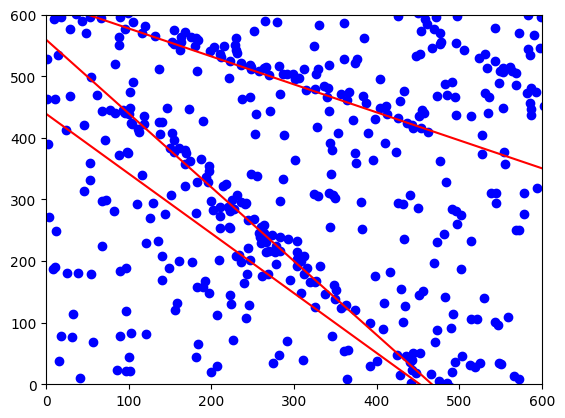

In [ ]:

if __name__ == "__main__":
    points = generate_data(15.0, 100, 300, 3, (600, 600))

    plt.scatter(points[:, 0], points[:, 1], c='b', marker='o')

    inliers, best_lines = multi_ransac(points, 10.0, 0.99, 1000, 3)

    for line_idx in range(best_lines.shape[0]):
        a, b, c = best_lines[line_idx]
        x = np.linspace(0, 600, 600)
        y = (-a * x - c) / b
        plt.plot(x, y, '-r')

    plt.xlim([0, 600])
    plt.ylim([0, 600])
    plt.show()